In [1]:
%%bash
pip install pytorch-lightning torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random

import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn import compose, preprocessing, pipeline
import torch
from torch import nn, optim, utils
import torch.nn.functional as F

# Implementing a Basic Graph Convolution

In [3]:
G = nx.Graph()
G.add_nodes_from([
    (1, {"color": "blue"}),
    (2, {"color": "orange"}),
    (3, {"color": "blue"}),
    (4, {"color": "green"})
])
G.add_edges_from([(1,2), (2,3), (1,3), (3,4)])

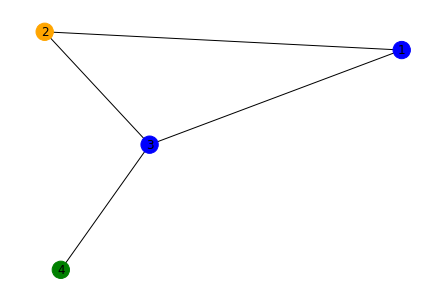

In [4]:
color_map = (nx.get_node_attributes(G, 'color')
               .values())
nx.draw(G,with_labels=True, node_color=color_map)

In [5]:
A = torch.from_numpy(nx.adjacency_matrix(G).todense().astype(np.float32))

In [6]:
A

tensor([[0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 0., 1.],
        [0., 0., 1., 0.]])

In [7]:
adjacency_matrix_extractor = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda G: nx.adjacency_matrix(G).todense()),
    preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X)),

)

ordinal_features_encoder = pipeline.make_pipeline(
    preprocessing.OneHotEncoder(sparse=False),
)

numeric_features_encoder = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda df: df.to_numpy()),
    preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X))
)

node_features_transformer = compose.make_column_transformer(
    (ordinal_features_encoder, ["color"]),
    (numeric_features_encoder, ["degree"]),
)

to_tensor_transformer = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X))
)

node_features_encoder = pipeline.make_pipeline(
    node_features_transformer,
    to_tensor_transformer,
)

In [8]:
A = adjacency_matrix_extractor.fit_transform(G)

In [9]:
A

tensor([[0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 0., 1.],
        [0., 0., 1., 0.]])

In [10]:
ordinal_features = (pd.DataFrame
                      .from_dict(G.nodes, orient="index"))
numeric_features = (pd.DataFrame
                      .from_dict({"degree": {k: v for k, v in G.degree}}))
node_features = ordinal_features.join(numeric_features)

In [11]:
node_features.head()

,color,degree
1,blue,2
2,orange,2
3,blue,3
4,green,1


In [12]:
encoded_node_features = node_features_encoder.fit_transform(node_features)

In [13]:
encoded_node_features

tensor([[1., 0., 0., 2.],
        [0., 0., 1., 2.],
        [1., 0., 0., 3.],
        [0., 1., 0., 1.]])

## Example graph convolution

In [14]:
X = encoded_node_features
f_in, f_out = X.shape[1], 6
W_1 = nn.Parameter(torch.rand(f_in, f_out))
W_2 = nn.Parameter(torch.rand(f_in, f_out))
b = nn.Parameter(torch.zeros(f_out))

# forward pass of a single graph convolution
h = (X @ W_1) + (A @ (X @ W_2)) + b

In [15]:
h

tensor([[4.6012, 2.9586, 4.4601, 4.4922, 5.8428, 2.7799],
        [4.9472, 2.8720, 4.9255, 2.8818, 5.2103, 1.9023],
        [6.4114, 3.8736, 5.0277, 5.2232, 7.1219, 3.2468],
        [2.3078, 1.9971, 2.6800, 2.4211, 3.3811, 1.7951]],
       grad_fn=<AddBackward0>)

# Implementing a GNN from scratch using PyTorch

## Implementing a basic graph convolution layer 

In [16]:
class GNNConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        # define and initialize parameters
        self.W1 = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.xavier_normal_(self.W1)
        self.W2 = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.xavier_normal_(self.W2)
        self.bias = nn.Parameter(torch.empty(out_channels))
        nn.init.constant_(self.bias, 0.0)

    def forward(self, X, A):
        root_update = X @ self.W1
        potential_msgs = X @ self.W2
        propagated_msgs = A @ potential_msgs
        output = root_update + propagated_msgs + self.bias
        return output


In [17]:
conv_1 = GNNConv(in_channels=4, out_channels=6) 

In [18]:
conv_1.forward(encoded_node_features, A)

tensor([[ 2.8209, -2.3703, -0.8747, -0.9069, -0.5379, -2.3189],
        [ 2.2868, -3.5675, -0.2881, -2.2488,  0.7193, -1.7606],
        [ 3.4291, -2.7010, -1.2446, -0.5059, -1.2147, -3.6122],
        [ 1.3342, -1.5868, -1.2253, -0.7204, -0.1433, -0.3873]],
       grad_fn=<AddBackward0>)

### Implmementing a basic graph neural network



In [19]:
class GNNRegressor(pl.LightningModule):

    def __init__(self, in_channels):
        super().__init__()

        self.conv_1 = GNNConv(in_channels, 32)
        self.conv_2 = GNNConv(32, 32)
        self.linear_1 = torch.nn.Linear(32, 16)
        self.linear_2 = torch.nn.Linear(16, 1)

    @staticmethod
    def global_add_pooling(X, B=None):
        if B is None or B.dim() == 1:
            return torch.sum(X, dim=0).unsqueeze(0)
        else:
            return B @ X

    def forward(self, X, A, B):
        Z = F.relu(self.conv_1(X, A))
        Z = F.relu(self.conv_2(Z, A))
        Z = self.global_add_pooling(Z, B)
        Z = self.linear_1(Z)
        Z = F.relu(Z)
        Z = self.linear_2(Z)
        return Z

    def training_step(self, collated_batch, batch_idx):
        logits = self.forward(
            collated_batch['X'],
            collated_batch['A'],
            collated_batch['B']
        )
        batch_size = len(collated_batch['B']) 
        loss = F.mse_loss(logits, collated_batch['y'])
        self.log("train_loss", loss, batch_size=batch_size)
        return loss

    def validation_step(self, collated_batch, batch_idx):
        logits = self.forward(
            collated_batch['X'],
            collated_batch['A'],
            collated_batch['B']
        )
        batch_size = len(collated_batch['B']) 
        loss = F.mse_loss(logits, collated_batch['y'])
        self.log("val_loss", loss, batch_size=batch_size)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters())


# Creating a graph Dataset and DataLoader

## Generate some random graphs

In [20]:
max_number_nodes = 100
number_graphs = 10

node_colors = [
    "blue",
    "green",
    "orange",    
]

graphs = []
for _ in range(number_graphs):
    number_nodes = random.choice(range(max_number_nodes))
    graph = nx.random_graphs.fast_gnp_random_graph(number_nodes, p=0.1)
    values = {i: random.choice(node_colors) for i in graph.nodes}
    nx.set_node_attributes(graph, values, name="color")
    graphs.append(graph)


In [21]:
prepared_graphs = []
for graph in graphs:
    ordinal_features = (pd.DataFrame
                          .from_dict(graph.nodes, orient="index"))
    numeric_features = (pd.DataFrame
                          .from_dict({"degree": {k: v for k, v in graph.degree}}))
    node_features = ordinal_features.join(numeric_features)
    A = adjacency_matrix_extractor.fit_transform(graph)
    X = node_features_encoder.fit_transform(node_features)
    possible_edges = (graph.number_of_edges() * (graph.number_of_edges() - 1) / 2)
    y = torch.tensor([[graph.number_of_edges() / possible_edges]])
    prepared_graphs.append({'A': A, 'X': X, 'y': y})

### Wrap code as a custom PyTorch Dataset

In [22]:
class GraphDataset(utils.data.Dataset):

    def __init__(self, graphs):

        self._adjacency_matrix_extractor = pipeline.make_pipeline(
            preprocessing.FunctionTransformer(lambda G: nx.adjacency_matrix(G).todense()),
            preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
            preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X)),
        )
        ordinal_features_encoder = pipeline.make_pipeline(
            preprocessing.OneHotEncoder(sparse=False),
        )
        numeric_features_encoder = pipeline.make_pipeline(
            preprocessing.FunctionTransformer(lambda df: df.to_numpy()),
        )
        node_features_transformer = compose.make_column_transformer(
            (ordinal_features_encoder, ["color"]),
            (numeric_features_encoder, ["degree"]),
        )
        to_tensor_transformer = pipeline.make_pipeline(
            preprocessing.FunctionTransformer(lambda X: X.astype(np.float32)),
            preprocessing.FunctionTransformer(lambda X: torch.from_numpy(X)),
        )
        self._node_features_encoder = pipeline.make_pipeline(
            node_features_transformer,
            to_tensor_transformer
        )
        self._prepared_graphs = self._prepare(graphs)
    
    def __len__(self):
        return len(self._prepared_graphs)
    
    def __getitem__(self, idx):
        return self._prepared_graphs[idx]

    def _prepare(self, graphs):
        prepared_graphs = []
        for graph in graphs:
            ordinal_features = (pd.DataFrame
                                  .from_dict(graph.nodes, orient="index"))
            numeric_features = (pd.DataFrame
                                  .from_dict({"degree": {k: v for k, v in graph.degree}}))
            node_features = ordinal_features.join(numeric_features)
            A = self._adjacency_matrix_extractor.fit_transform(graph)
            X = self._node_features_encoder.fit_transform(node_features)
            possible_edges = (graph.number_of_edges() * (graph.number_of_edges() - 1) / 2)
            y = torch.tensor([[graph.number_of_edges() / possible_edges]])
            prepared_graphs.append({'A': A, 'X': X, 'y': y})
        return prepared_graphs


### Create the graph selection mask

In [23]:
def make_graph_selection_mask(graph_sizes):
    starts = [sum(graph_sizes[:i]) for i in range(len(graph_sizes))]
    stops = [starts[i] + graph_sizes[i] for i in range(len(graph_sizes))]
    B = torch.zeros(len(graph_sizes), sum(graph_sizes))
    for i, (start, stop) in enumerate(zip(starts, stops)):
        B[i, start:stop] = 1
    return B

In [24]:
graph_sizes = [len(graph['A']) for graph in prepared_graphs]
make_graph_selection_mask(graph_sizes)

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

### Need to collate each batch of graphs

In [25]:
torch.block_diag?

In [26]:
def collate(batch):
    # combine adjacency matrices (will be block diagonal)
    A = torch.block_diag(*[graph['A'] for graph in batch])
    # create graph selection mask
    graph_sizes = [len(graph['A']) for graph in batch]
    B = make_graph_selection_mask(graph_sizes)    
    # combine feature matrices (each graph has same number of node features)
    X = torch.cat([graph['X'] for graph in batch], dim=0)
    # combine labels
    y = torch.cat([graph['y'] for graph in batch], dim=0) 
    collated_graph_data = {'A': A, 'X': X, 'y': y, 'B': B}
    return collated_graph_data

### Wrap your code into Lightning DataModule

In [27]:
class GraphDataModule(pl.LightningDataModule):

    def __init__(self, graphs, batch_size=1, val_size=0.1):
        super().__init__()
        self._batch_size = batch_size
        self._graphs = graphs
        self._val_size = val_size

    @staticmethod
    def _make_graph_selection_mask(graph_sizes):
        starts = [sum(graph_sizes[:i]) for i in range(len(graph_sizes))]
        stops = [starts[i] + graph_sizes[i] for i in range(len(graph_sizes))]
        B = torch.zeros(len(graph_sizes), sum(graph_sizes))
        for i, (start, stop) in enumerate(zip(starts, stops)):
            B[i, start:stop] = 1
        return B

    @classmethod
    def _collate_fn(cls, batch):
        # combine adjacency matrices (will be block diagonal)
        A = torch.block_diag(*[graph['A'] for graph in batch])
        # create graph selection mask
        graph_sizes = [len(graph['A']) for graph in batch]
        B = cls._make_graph_selection_mask(graph_sizes)    
        # combine feature matrices (each graph has same number of node features)
        X = torch.cat([graph['X'] for graph in batch], dim=0)
        # combine labels
        y = torch.cat([graph['y'] for graph in batch], dim=0) 
        collated_graph_data = {'A': A, 'X': X, 'y': y, 'B': B}
        return collated_graph_data

    def prepare_data(self):
        pass

    def setup(self, stage=None):

        # assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            random.shuffle(self._graphs)
            n = int(self._val_size * len(self._graphs))
            train_graphs, val_graphs = self._graphs[:n], self._graphs[n:]
            self.train_dataset = GraphDataset(train_graphs)
            self.val_dataset = GraphDataset(val_graphs)

    def train_dataloader(self):
        return utils.data.DataLoader(
            self.train_dataset,
            batch_size=self._batch_size,
            collate_fn=self._collate_fn,
        )

    def val_dataloader(self):
        return utils.data.DataLoader(
            self.val_dataset,
            batch_size=self._batch_size,
            collate_fn=self._collate_fn,
        )


## Define model and data module and train

In [28]:
gnn = GNNRegressor(in_channels=4)
graph_datamodule = GraphDataModule(graphs, batch_size=2, val_size=0.1)

In [29]:
_hyperparameters = {
    "max_epochs": 200,
    "log_every_n_steps": 1,
}
trainer = pl.Trainer(**_hyperparameters)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(gnn, datamodule=graph_datamodule)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | conv_1   | GNNConv | 288   
1 | conv_2   | GNNConv | 2.1 K 
2 | linear_1 | Linear  | 528   
3 | linear_2 | Linear  | 17    
-------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]